In [1]:
from text_analyzer.file_manager import FileManager
from collections import Counter
from nltk.util import ngrams
import json
import re
import pandas as pd

class Analyzer(FileManager):

    def __init__(self):
        self.data = None
        self.document_count = None
        self.char_number = None
        self.word_number = None
        self.non_alpha_chars = None
        self.ngram_dict = None
        
    def __str__(self):
        if isinstance(self.data, pd.DataFrame):
            return f"Analyzer object with {len(self.data)} documents.\nUse print_stats() method to see stats."
        else:
            return "Use read_csv() or read_txt() methods to read data first."
    
    def __repr__(self):
        if isinstance(self.data, pd.DataFrame):
            return f"Analyzer object with {len(self.data)} documents.\nUse print_stats() method to see stats."
        else:
            return "Use read_csv() or read_txt() methods to read data first."
    
    def read_csv(self, path: str, column_name:str='text', encoding='utf-8'):
        self.data = self.load_csv(path, column_name, encoding)
        self.analyze()

    def read_txt(self, path, delimiter='\n'):
        self.data = self.load_txt(path, delimiter)
        print(self.data.head())
        self.analyze()

    def analyze(self):
        """Analyze data and update class attributes."""
        self.document_count = len(self.data)
        self.data = self._preprocess_data(self.data)
        self.char_number = self._calculate_char_number()
        self.word_number = self._calculate_word_number()
        self.non_alpha_chars = self._count_non_alpha_chars()
        self.ngram_dict = self._calculate_most_used_ngrams()

    def _preprocess_data(self, data: pd.DataFrame):
        """First check the format of the data then preprocess data and add preprocessed text column to data."""
        if not isinstance(data, pd.DataFrame):
            raise TypeError("Data should be a pandas DataFrame.")
        if 'text' not in data.columns:
            raise ValueError("Data should have a column named text.")
        
        data['preprocessed_text'] = data['text'].apply(lambda x: x.lower())
        data['processed_text'] = data['text'].apply(self._preprocessing)
        return data
    
    def _preprocessing(self, text: str):
        """lower, remove punctuations, remove numbers, remove whitespaces. Use regex."""
        text = text.lower()

        text = re.sub(r'[^\w\s]','', text)
        text = re.sub(r'\d','', text)
        text = re.sub(r'\s+',' ', text)
        text = re.sub(r' +', ' ', text)
        text = re.sub(r'\n', ' ', text)
        return text.strip()
    
    def _calculate_char_number(self):
        """calculate number of chars for each doc. Return min, max, mean values as dict"""
        self.data['n_char'] = self.data['text'].apply(lambda x: len(x))
        return self.data['n_char'].agg(['min', 'mean', 'max', 'sum']).to_dict()
    
    def _calculate_word_number(self):
        """calculate number of words for each doc. Return min, max, mean values as dict"""
        self.data['n_word'] = self.data['text'].apply(lambda x: len(x.split()))
        return self.data['n_word'].agg(['min', 'mean', 'max', 'sum']).to_dict()
    
    def _count_non_alpha_chars(self, n=10):
        non_alpha_chars = Counter()
        total_non_alpha_count = 0
        
        for text in self.data['text']:
            non_alpha = [char for char in text if not char.isalpha() and not char.isspace()]
            non_alpha_chars.update(non_alpha)
            total_non_alpha_count += len(non_alpha)
        
        return {"10_most_common_with_freq": dict(non_alpha_chars.most_common(n)),
                "total_count": total_non_alpha_count}
    
    def _calculate_most_used_ngrams(self, n_min=1, n_max=3, first_k=10):
        """calculate most used ngrams for each doc. Return dict of ngrams. Keys are n values. Values are dicts of ngrams and their frequencies. n_min and n_max are used to determine n values. first_k is used to determine how many ngrams will be returned."""
        text_splitted = [word for sentence in self.data['preprocessed_text'].tolist() for word in sentence.split()]
        ngram_dict = dict()
        for n in range(n_min, n_max+1):
            ngram = Counter(ngrams(text_splitted, n)).most_common(first_k)
            ngram_freq = {" ".join(phrase): freq for phrase, freq in ngram}
            ngram_dict[n] = ngram_freq

        return ngram_dict

    def generate_word_cloud(self, use_processed_data=True, save=False, output_name='word_cloud.png'):
        """import wordcloud library and generate a single word cloud with all the documents"""
        from wordcloud import WordCloud
        import matplotlib.pyplot as plt

        data = self.data['processed_text'].tolist() if use_processed_data else self.data['text'].tolist()
        world_cloud = WordCloud(width=800, height=800, background_color='white',
                                 min_font_size=10).generate(" ".join(data))
        plt.axis('off')
        plt.imshow(world_cloud, interpolation='bilinear')
        if save:
            world_cloud.to_file(output_name)
        plt.show()
    
    def print_stats(self, pretty=True):
        analyzer_dict = self.__dict__.copy()
        analyzer_dict.pop('data')
        
        res = json.dumps(analyzer_dict, indent=4 if pretty else None)
        print(res)
        
    def to_json(self, output_name: str):
        analyzer_dict = self.__dict__.copy()
        analyzer_dict.pop('data')
        self._to_json(analyzer_dict, output_name)

    def to_txt(self, output_name):
        analyzer_dict = self.__dict__.copy()
        analyzer_dict.pop('data')
        
        self._to_txt(analyzer_dict, output_name)



In [3]:

analyzer = Analyzer()
analyzer.read_txt('text_analyzer/val.txt')
print(analyzer)
analyzer.print_stats()
# analyzer.to_txt('analyzer.json')

                                                text
0  Lorem ipsum dolor sit amet, consectetur adipis...
1  Pellentesque habitant morbi tristique senectus...
2  Quisque suscipit elit nec convallis ullamcorpe...
3  Lorem ipsum dolor sit amet, çonsectetur adipis...
4  Pellentesque habitant morbi tristique senectus...
Analyzer object with 8 documents.
Use print_stats() method to see stats.
{
    "document_count": 8,
    "char_number": {
        "min": 390.0,
        "mean": 507.75,
        "max": 610.0,
        "sum": 4062.0
    },
    "word_number": {
        "min": 58.0,
        "mean": 74.25,
        "max": 91.0,
        "sum": 594.0
    },
    "non_alpha_chars": {
        "10_most_common_with_freq": {
            ".": 83,
            ",": 38,
            "5": 4,
            "/": 2,
            "1": 2,
            ":": 1,
            "+": 1,
            "(": 1,
            ")": 1,
            "2": 1
        },
        "total_count": 139
    },
    "ngram_dict": {
        "1": {
      

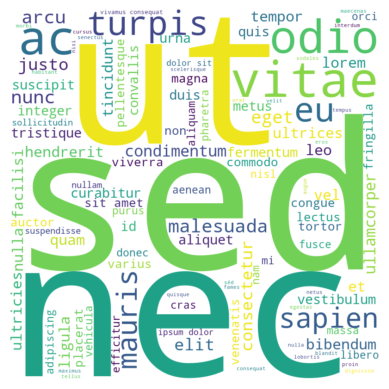

In [17]:
anlyz.generate_word_cloud()

In [ ]:
anlyz.print_stats()

In [21]:
analyzer = Analyzer()
analyzer.read_txt('text_analyzer/val.txt')
analyzer

                                                text
0  Lorem ipsum dolor sit amet, consectetur adipis...
1  Pellentesque habitant morbi tristique senectus...
2  Quisque suscipit elit nec convallis ullamcorpe...
3  Lorem ipsum dolor sit amet, çonsectetur adipis...
4  Pellentesque habitant morbi tristique senectus...


Analyzer object with 8 documents.
Use print_stats() method to see stats.

In [4]:
analyzer.to_json('testing')
# anlyz.to_txt('testing')

In [15]:
if analyzer.data != None:
    print("ok")


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [19]:
if isinstance(None, pd.DataFrame):
    print("ok")